In [17]:
import pylab
import calendar
import numpy as np
import pandas as pd
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', category=DeprecationWarning)

print(os.listdir('../data/kaggle_bike'))

['.DS_Store', 'sampleSubmission.csv', 'test.csv', 'output', 'train.csv']


In [28]:
df_train = pd.read_csv('../data/kaggle_bike/train.csv')
df_test = pd.read_csv('../data/kaggle_bike/test.csv')

In [29]:
print(df_train.shape, df_test.shape)

(10886, 12) (6493, 9)


In [30]:
df_train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [31]:
df_train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [32]:
def kesson_table(df):
    total = df.isnull().sum()
    percent = total / len(df) * 100
    kesson_table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    kesson_table = kesson_table.drop(kesson_table[kesson_table['Total']==0].index)
    return kesson_table

In [33]:
df_train['date'] = df_train['datetime'].apply(lambda x: x.split()[0])
df_train['hour'] = df_train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
df_train['weekday'] = df_train['date'].apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df_train["month"] = df_train['date'].apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
df_train['season'] = df_train['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4:'Winter'})
df_train['weather'] = df_train['weather'].map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

In [34]:
categoryVariableList = ['hour', 'weekday', 'month', 'season', 'weather', 'holiday', 'workingday']
for var in categoryVariableList:
    df_train[var] = df_train[var].astype('category')

In [35]:
df_train.drop(['datetime'], axis=1, inplace=True)

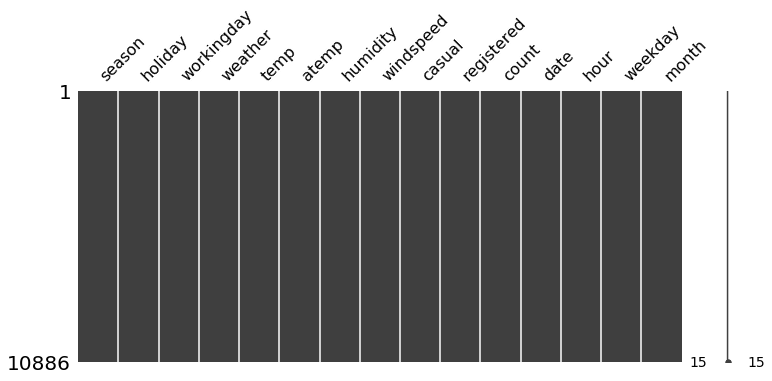

In [44]:
msno.matrix(df_train, figsize=(12, 5))

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

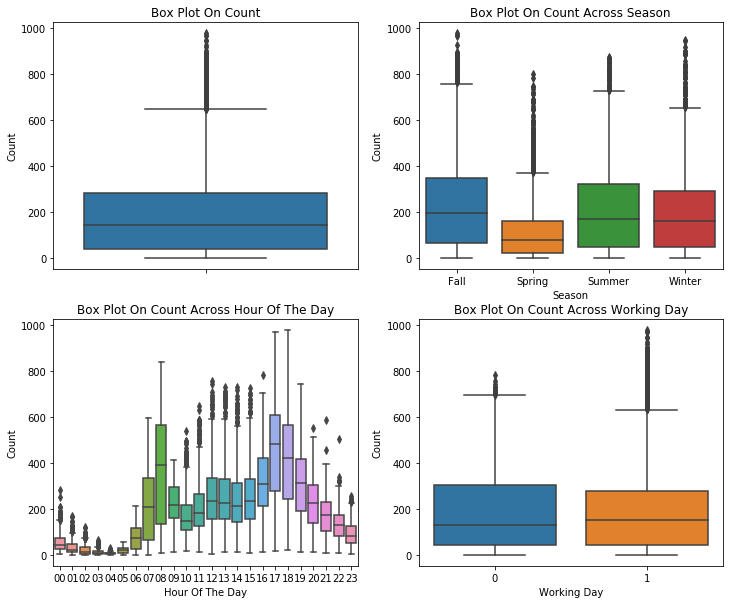

In [47]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(12, 10)
sns.boxplot(data=df_train, y="count", orient="v", ax=axes[0][0])
sns.boxplot(data=df_train, y="count", x="season", orient="v", ax=axes[0][1])
sns.boxplot(data=df_train, y="count", x="hour", orient="v", ax=axes[1][0])
sns.boxplot(data=df_train, y="count", x="workingday", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [48]:
dailyDataWithoutOutliers = df_train[np.abs(df_train["count"]-df_train["count"].mean())<=(3*df_train["count"].std())] 

In [49]:
print ("Shape Of The Before Ouliers: ",df_train.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


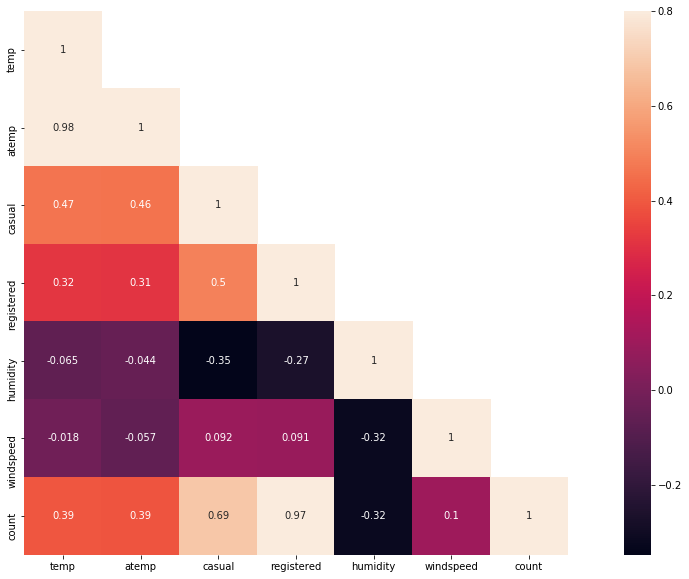

In [51]:
corrMatt = df_train[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

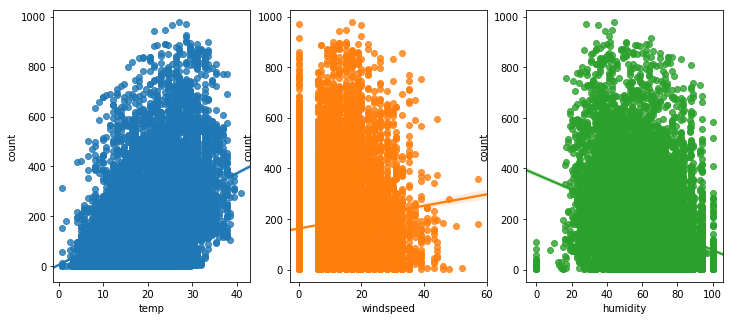

In [53]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=df_train, ax=ax1)
sns.regplot(x="windspeed", y="count", data=df_train, ax=ax2)
sns.regplot(x="humidity", y="count", data=df_train, ax=ax3)

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

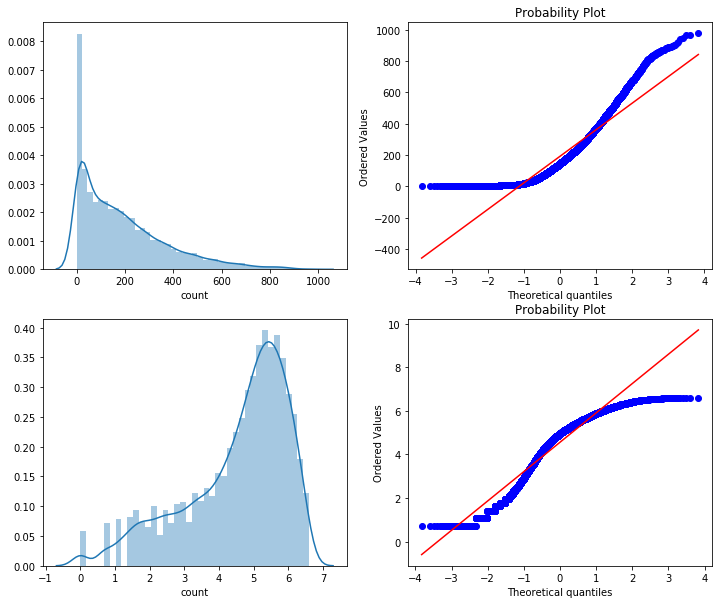

In [55]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(df_train["count"],ax=axes[0][0])
stats.probplot(df_train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(dailyDataWithoutOutliers["count"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

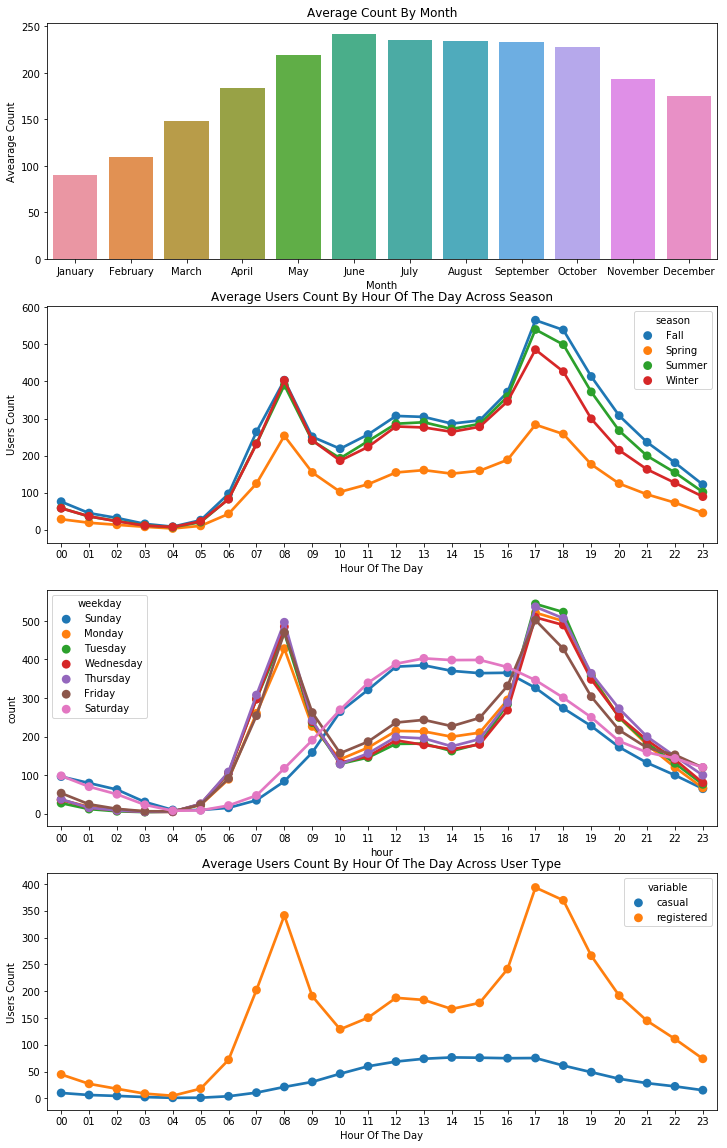

In [76]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(df_train.groupby("month")["count"].mean()).reset_index()
#monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthAggregated,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(df_train.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(df_train.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)

hourTransformed = pd.melt(df_train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across User Type",label='big')